In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [330]:
import warnings
warnings.filterwarnings("ignore")

In [331]:
df = pd.read_csv('df_renamed.csv', index_col='datetime', encoding='latin1', parse_dates=True, dayfirst=True)

In [332]:
df.head(2)

,count,temp,humidity,wind_speed,visibility,dew_point_temp,solar_radiation,rainfall,snowfall,seasons,holiday,functioning_day,date,year,month,day,hour
datetime,,,,,,,,,,,,,,,,,
2017-12-01 00:00:00,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01,2017,12,1,0
2017-12-01 01:00:00,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017-12-01,2017,12,1,1


In [333]:
df.shape

(8760, 17)

# Feature Engineering

##### (this section is for regression purpose)

##### (train test split for the purpose of time series analysis will be  in later section)

### Train test split

In [334]:
# before train test split, need to transform some variables on the whole dataset
# for the sake of future feature engineering

# because the  future log transformation cannot process zero or negative values
# therefore, it is necessary to add a constant value to such variables
# such variables every numeric variable except "visibility"
# I decide to add a constant value of 50 to all those variables

# save the old copy as csv
df_before_adding_constant = df.copy


df['count_transformed'] = df['count'].apply(lambda x: x+50)
df['temp_transformed'] = df['temp'].apply(lambda x: x+50)
df['humidity_transformed'] = df['humidity'].apply(lambda x: x+50)
df['wind_speed_transformed'] = df['wind_speed'].apply(lambda x: x+50)
df['dew_point_temp_transformed'] = df['dew_point_temp'].apply(lambda x: x+50)
df['solar_radiation_transformed'] = df['solar_radiation'].apply(lambda x: x+50)
df['rainfall_transformed'] = df['rainfall'].apply(lambda x: x+50)
df['snowfall_transformed'] = df['snowfall'].apply(lambda x: x+50)

In [335]:
df.columns

Index(['count', 'temp', 'humidity', 'wind_speed', 'visibility',
       'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall', 'seasons',
       'holiday', 'functioning_day', 'date', 'year', 'month', 'day', 'hour',
       'count_transformed', 'temp_transformed', 'humidity_transformed',
       'wind_speed_transformed', 'dew_point_temp_transformed',
       'solar_radiation_transformed', 'rainfall_transformed',
       'snowfall_transformed'],
      dtype='object')

In [336]:
# delete old columns
df.drop(columns=['count', 'temp', 'humidity', 'wind_speed',
       'dew_point_temp', 'solar_radiation', 'rainfall', 'snowfall', 'date', 'year', 'month', 'day', 'hour'], inplace=True)

In [337]:
df.head(2)

,visibility,seasons,holiday,functioning_day,count_transformed,temp_transformed,humidity_transformed,wind_speed_transformed,dew_point_temp_transformed,solar_radiation_transformed,rainfall_transformed,snowfall_transformed
datetime,,,,,,,,,,,,
2017-12-01 00:00:00,2000,Winter,No Holiday,Yes,304,44.8,87,52.2,32.4,50.0,50.0,50.0
2017-12-01 01:00:00,2000,Winter,No Holiday,Yes,254,44.5,88,50.8,32.4,50.0,50.0,50.0


In [338]:
# Train test split before feature engineering to avoid data leakage
# Processing on the test set should be propogated from the training set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :], df.iloc[:, 4], test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7008, 12), (1752, 12), (7008,), (1752,))

### Plan

In [339]:
# Plan:

# Categorical variables encoding:
# "seasons": target-guided encoding
# "holiday": OneHotEncoding
# "functioning_day": OneHotEncoding

# Numerical varaible transformation: log

# Feature scaling: Standardization

### Categorical variable encoding

##### "season" - target-guided encoding

In [340]:
# "seasons" - target-guided encoding
# encoded by the seasonal variation (lowest to highest)
# winter - spring - autum - spring

In [341]:
# let's explore the relationship of the categories with the target

spring = df[df['seasons'] == 'Spring']
summer = df[df['seasons'] == 'Summer']
autumn = df[df['seasons'] == 'Autumn']
winter = df[df['seasons'] == 'Winter']

print('spring: ', round(spring['count_transformed'].mean(),0)-50, "per hour")
print('summer: ', round(summer['count_transformed'].mean(),0)-50, "per hour")
print('autumn: ', round(autumn['count_transformed'].mean(), 0)-50, "per hour")
print('winter: ', round(winter['count_transformed'].mean(),0)-50, "per hour")

spring:  730.0 per hour
summer:  1034.0 per hour
autumn:  820.0 per hour
winter:  226.0 per hour


In [342]:
# order the season labels according to the mean target value
X_train.groupby(['seasons'])['count_transformed'].mean().sort_values()

seasons
Winter     275.813805
Spring     783.547782
Autumn     866.887882
Summer    1099.292614
Name: count_transformed, dtype: float64

In [343]:
# generate an ordered list with the labels
ordered_labels = X_train.groupby(['seasons'])['count_transformed'].mean().sort_values().index

ordered_labels

Index(['Winter', 'Spring', 'Autumn', 'Summer'], dtype='object', name='seasons')

In [344]:
# create a dictionary with the mappings of categories to numbers

ordinal_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}

ordinal_mapping

{'Winter': 0, 'Spring': 1, 'Autumn': 2, 'Summer': 3}

In [345]:
# replace the labels with the integers (results propogated from training to test set)

X_train['seasons'] = X_train['seasons'].map(ordinal_mapping)
X_test['seasons'] = X_test['seasons'].map(ordinal_mapping)

In [346]:
# check the results
X_train['seasons'].head(10)

datetime
2018-02-23 15:00:00    0
2018-08-31 18:00:00    3
2018-08-23 11:00:00    3
2018-04-25 10:00:00    1
2018-10-17 20:00:00    2
2018-04-10 16:00:00    1
2018-09-23 18:00:00    2
2018-08-23 16:00:00    3
2018-09-21 15:00:00    2
2018-09-30 22:00:00    2
Name: seasons, dtype: int64

In [347]:
X_test['seasons'].head()

datetime
2018-05-19 03:00:00    1
2018-09-15 02:00:00    2
2017-12-10 17:00:00    0
2018-01-10 22:00:00    0
2018-08-06 15:00:00    3
Name: seasons, dtype: int64

In [348]:
X_train.head()

,visibility,seasons,holiday,functioning_day,count_transformed,temp_transformed,humidity_transformed,wind_speed_transformed,dew_point_temp_transformed,solar_radiation_transformed,rainfall_transformed,snowfall_transformed
datetime,,,,,,,,,,,,
2018-02-23 15:00:00,291,0,No Holiday,Yes,362,58.2,112,50.6,51.3,51.22,50.0,50.0
2018-08-31 18:00:00,2000,3,No Holiday,Yes,2886,78.4,107,52.4,69.0,50.84,50.0,50.0
2018-08-23 11:00:00,1992,3,No Holiday,Yes,761,79.9,107,51.7,70.4,50.88,50.1,50.0
2018-04-25 10:00:00,1749,1,No Holiday,Yes,806,64.8,79,50.6,47.0,52.20,50.0,50.0
2018-10-17 20:00:00,2000,2,No Holiday,Yes,1608,62.2,97,51.1,51.2,50.00,50.0,50.0


##### "holiday" & 'functioning_day" - OneHotEncoding

In [349]:
X_train_cat = X_train[['holiday', 'functioning_day']]
X_test_cat = X_test[['holiday', 'functioning_day']]

In [350]:
X_test_cat.head()

,holiday,functioning_day
datetime,,
2018-05-19 03:00:00,No Holiday,Yes
2018-09-15 02:00:00,No Holiday,Yes
2017-12-10 17:00:00,No Holiday,Yes
2018-01-10 22:00:00,No Holiday,Yes
2018-08-06 15:00:00,No Holiday,Yes


In [351]:
X_train_rest = X_train.drop(X_train_cat, axis=1)
X_test_rest = X_test.drop(X_test_cat, axis=1)

In [352]:
X_train_rest.head()

,visibility,seasons,count_transformed,temp_transformed,humidity_transformed,wind_speed_transformed,dew_point_temp_transformed,solar_radiation_transformed,rainfall_transformed,snowfall_transformed
datetime,,,,,,,,,,
2018-02-23 15:00:00,291,0,362,58.2,112,50.6,51.3,51.22,50.0,50.0
2018-08-31 18:00:00,2000,3,2886,78.4,107,52.4,69.0,50.84,50.0,50.0
2018-08-23 11:00:00,1992,3,761,79.9,107,51.7,70.4,50.88,50.1,50.0
2018-04-25 10:00:00,1749,1,806,64.8,79,50.6,47.0,52.20,50.0,50.0
2018-10-17 20:00:00,2000,2,1608,62.2,97,51.1,51.2,50.00,50.0,50.0


In [353]:
# obtain k-1 labels
X_train_cat = pd.get_dummies(X_train_cat[['holiday', 'functioning_day']], drop_first=True)
X_test_cat = pd.get_dummies(X_test_cat[['holiday', 'functioning_day']], drop_first=True)

In [354]:
X_train_cat.head()

,holiday_No Holiday,functioning_day_Yes
datetime,,
2018-02-23 15:00:00,1,1
2018-08-31 18:00:00,1,1
2018-08-23 11:00:00,1,1
2018-04-25 10:00:00,1,1
2018-10-17 20:00:00,1,1


In [355]:
# concat back together
X_train = pd.concat([X_train_cat, X_train_rest], axis=1)

In [356]:
X_test = pd.concat([X_test_cat, X_test_rest], axis=1)

In [357]:
X_train.head()

,holiday_No Holiday,functioning_day_Yes,visibility,seasons,count_transformed,temp_transformed,humidity_transformed,wind_speed_transformed,dew_point_temp_transformed,solar_radiation_transformed,rainfall_transformed,snowfall_transformed
datetime,,,,,,,,,,,,
2018-02-23 15:00:00,1,1,291,0,362,58.2,112,50.6,51.3,51.22,50.0,50.0
2018-08-31 18:00:00,1,1,2000,3,2886,78.4,107,52.4,69.0,50.84,50.0,50.0
2018-08-23 11:00:00,1,1,1992,3,761,79.9,107,51.7,70.4,50.88,50.1,50.0
2018-04-25 10:00:00,1,1,1749,1,806,64.8,79,50.6,47.0,52.20,50.0,50.0
2018-10-17 20:00:00,1,1,2000,2,1608,62.2,97,51.1,51.2,50.00,50.0,50.0


In [358]:
X_train.columns

Index(['holiday_No Holiday', 'functioning_day_Yes', 'visibility', 'seasons',
       'count_transformed', 'temp_transformed', 'humidity_transformed',
       'wind_speed_transformed', 'dew_point_temp_transformed',
       'solar_radiation_transformed', 'rainfall_transformed',
       'snowfall_transformed'],
      dtype='object')

### Numerical variable transformation

In [359]:
# Noted:
# 'temp' and 'dew_point_temp' variables contain negative values
# therefore, before log transformation, another transformation is needed

# I decide to add a constant value of 50 to ensure all values positive

In [360]:
# for future comparison use
X_train_before_log = X_train.copy()
X_test_before_log = X_train.copy()

In [361]:
X_train.columns

Index(['holiday_No Holiday', 'functioning_day_Yes', 'visibility', 'seasons',
       'count_transformed', 'temp_transformed', 'humidity_transformed',
       'wind_speed_transformed', 'dew_point_temp_transformed',
       'solar_radiation_transformed', 'rainfall_transformed',
       'snowfall_transformed'],
      dtype='object')

In [362]:
for var in ['visibility', 'count_transformed', 'temp_transformed', 'humidity_transformed',
       'wind_speed_transformed', 'dew_point_temp_transformed',
       'solar_radiation_transformed', 'rainfall_transformed',
       'snowfall_transformed']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

In [363]:
# check that training set does not contain null values in the engineered variables
[var for var in ['visibility', 'count_transformed', 'temp_transformed', 'humidity_transformed',
       'wind_speed_transformed', 'dew_point_temp_transformed',
       'solar_radiation_transformed', 'rainfall_transformed',
       'snowfall_transformed'] if X_train[var].isnull().sum()>0]

[]

In [364]:
# check that training set does not contain null values in the engineered variables
[var for var in ['visibility', 'count_transformed', 'temp_transformed', 'humidity_transformed',
       'wind_speed_transformed', 'dew_point_temp_transformed',
       'solar_radiation_transformed', 'rainfall_transformed',
       'snowfall_transformed'] if X_test[var].isnull().sum()>0]

[]

In [365]:
X_train

,holiday_No Holiday,functioning_day_Yes,visibility,seasons,count_transformed,temp_transformed,humidity_transformed,wind_speed_transformed,dew_point_temp_transformed,solar_radiation_transformed,rainfall_transformed,snowfall_transformed
datetime,,,,,,,,,,,,
2018-02-23 15:00:00,1,1,5.673323,0,5.891644,4.063885,4.718499,3.923952,3.937691,3.936130,3.912023,3.912023
2018-08-31 18:00:00,1,1,7.600902,3,7.967627,4.361824,4.672829,3.958907,4.234107,3.928683,3.912023,3.912023
2018-08-23 11:00:00,1,1,7.596894,3,6.634633,4.380776,4.672829,3.945458,4.254193,3.929470,3.914021,3.912023
2018-04-25 10:00:00,1,1,7.466799,1,6.692084,4.171306,4.369448,3.923952,3.850148,3.955082,3.912023,3.912023
2018-10-17 20:00:00,1,1,7.600902,2,7.382746,4.130355,4.574711,3.933784,3.935740,3.912023,3.912023,3.912023
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-01 05:00:00,1,1,7.098376,3,5.874931,4.216562,4.828314,3.931826,4.147885,3.912023,3.912023,3.912023
2018-10-25 19:00:00,1,1,7.434848,2,7.609862,4.195697,4.574711,3.931826,4.007333,3.912023,3.912023,3.912023
2018-06-21 11:00:00,1,1,6.849066,3,7.017506,4.324133,4.672829,3.947390,4.194190,3.970481,3.912023,3.912023


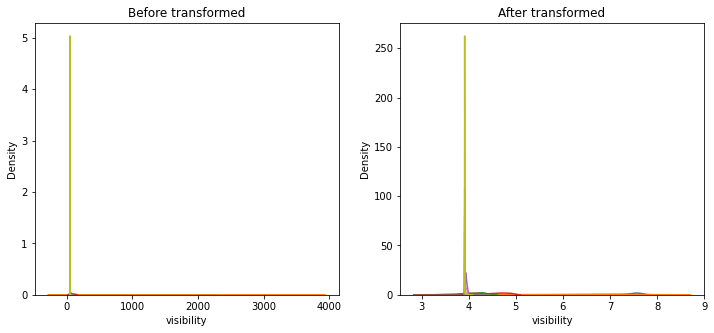

In [366]:
# compare the variable distributions before and after log transformation

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# before scaling
ax1.set_title('Before transformed')
sns.kdeplot(X_train_before_log['visibility'], ax=ax1)
sns.kdeplot(X_train_before_log['count_transformed'], ax=ax1)
sns.kdeplot(X_train_before_log['temp_transformed'], ax=ax1)
sns.kdeplot(X_train_before_log['humidity_transformed'], ax=ax1)
sns.kdeplot(X_train_before_log['wind_speed_transformed'], ax=ax1)
sns.kdeplot(X_train_before_log['dew_point_temp_transformed'], ax=ax1)
sns.kdeplot(X_train_before_log['solar_radiation_transformed'], ax=ax1)
sns.kdeplot(X_train_before_log['rainfall_transformed'], ax=ax1)
sns.kdeplot(X_train_before_log['snowfall_transformed'], ax=ax1)

# after scaling
ax2.set_title('After transformed')
sns.kdeplot(X_train['visibility'], ax=ax2)
sns.kdeplot(X_train['count_transformed'], ax=ax2)
sns.kdeplot(X_train['temp_transformed'], ax=ax2)
sns.kdeplot(X_train['humidity_transformed'], ax=ax2)
sns.kdeplot(X_train['wind_speed_transformed'], ax=ax2)
sns.kdeplot(X_train['dew_point_temp_transformed'], ax=ax2)
sns.kdeplot(X_train['solar_radiation_transformed'], ax=ax2)
sns.kdeplot(X_train['rainfall_transformed'], ax=ax2)
sns.kdeplot(X_train['snowfall_transformed'], ax=ax2)
plt.show()

### Feature scaling

In [367]:
# In future model building, we will use linear regression and svr
# because they are sensitive to feature magnitutde, we need to do feature scaling
# we decide to use standardization

In [368]:
# standard scale numeric variables except the target

In [369]:
X_train_before_scaled = X_train.copy()
X_test_before_scaled = X_test.copy()

In [370]:
X_train.columns

Index(['holiday_No Holiday', 'functioning_day_Yes', 'visibility', 'seasons',
       'count_transformed', 'temp_transformed', 'humidity_transformed',
       'wind_speed_transformed', 'dew_point_temp_transformed',
       'solar_radiation_transformed', 'rainfall_transformed',
       'snowfall_transformed'],
      dtype='object')

In [371]:
# capture all variables in a list, except the target

train_vars = [var for var in X_train.columns if var not in ['count_transformed']]
train_vars

['holiday_No Holiday',
 'functioning_day_Yes',
 'visibility',
 'seasons',
 'temp_transformed',
 'humidity_transformed',
 'wind_speed_transformed',
 'dew_point_temp_transformed',
 'solar_radiation_transformed',
 'rainfall_transformed',
 'snowfall_transformed']

In [372]:
# scaler, for standardization
from sklearn.preprocessing import StandardScaler

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the training set
scaler.fit(X_train[train_vars])

# transform training and test sets
X_train[train_vars] = scaler.transform(X_train[train_vars])
X_test[train_vars] = scaler.transform(X_test[train_vars])

In [373]:
# the scaler stores the mean and sd of the features
scaler.mean_, scaler.scale_

(array([0.94891553, 0.96775114, 7.11663767, 1.50827626, 4.12139739,
        4.66518295, 3.9457557 , 3.95583892, 3.92327855, 3.91471939,
        3.91350363]),
 array([0.22017005, 0.17666032, 0.64892344, 1.11544778, 0.20096568,
        0.19307414, 0.01995181, 0.26939052, 0.01708811, 0.01981654,
        0.00847697]))

In [374]:
# transform the NumPy arrays to dataframes
X_train = pd.DataFrame(X_train, columns = X_train.columns)
X_test = pd.DataFrame(X_test, columns = X_test.columns)

In [375]:
X_train_before_scaled.head()

,holiday_No Holiday,functioning_day_Yes,visibility,seasons,count_transformed,temp_transformed,humidity_transformed,wind_speed_transformed,dew_point_temp_transformed,solar_radiation_transformed,rainfall_transformed,snowfall_transformed
datetime,,,,,,,,,,,,
2018-02-23 15:00:00,1,1,5.673323,0,5.891644,4.063885,4.718499,3.923952,3.937691,3.936130,3.912023,3.912023
2018-08-31 18:00:00,1,1,7.600902,3,7.967627,4.361824,4.672829,3.958907,4.234107,3.928683,3.912023,3.912023
2018-08-23 11:00:00,1,1,7.596894,3,6.634633,4.380776,4.672829,3.945458,4.254193,3.929470,3.914021,3.912023
2018-04-25 10:00:00,1,1,7.466799,1,6.692084,4.171306,4.369448,3.923952,3.850148,3.955082,3.912023,3.912023
2018-10-17 20:00:00,1,1,7.600902,2,7.382746,4.130355,4.574711,3.933784,3.935740,3.912023,3.912023,3.912023


In [376]:
X_train.head()

,holiday_No Holiday,functioning_day_Yes,visibility,seasons,count_transformed,temp_transformed,humidity_transformed,wind_speed_transformed,dew_point_temp_transformed,solar_radiation_transformed,rainfall_transformed,snowfall_transformed
datetime,,,,,,,,,,,,
2018-02-23 15:00:00,0.232023,0.182547,-2.224167,-1.352171,5.891644,-0.286178,0.276142,-1.092839,-0.067368,0.752075,-0.136067,-0.174664
2018-08-31 18:00:00,0.232023,0.182547,0.746259,1.337332,7.967627,1.196356,0.039601,0.659133,1.032952,0.316296,-0.136067,-0.174664
2018-08-23 11:00:00,0.232023,0.182547,0.740082,1.337332,6.634633,1.290660,0.039601,-0.014932,1.107516,0.362320,-0.035242,-0.174664
2018-04-25 10:00:00,0.232023,0.182547,0.539604,-0.455670,6.692084,0.248342,-1.531718,-1.092839,-0.392335,1.861174,-0.136067,-0.174664
2018-10-17 20:00:00,0.232023,0.182547,0.746259,0.440831,7.382746,0.044573,-0.468587,-0.600006,-0.074611,-0.658677,-0.136067,-0.174664


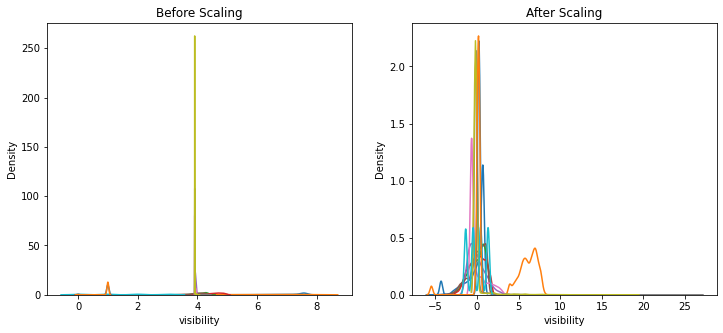

In [377]:
# compare the variable distributions before and after scaling

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(X_train_before_scaled['visibility'], ax=ax1)
sns.kdeplot(X_train_before_scaled['count_transformed'], ax=ax1)
sns.kdeplot(X_train_before_scaled['temp_transformed'], ax=ax1)
sns.kdeplot(X_train_before_scaled['humidity_transformed'], ax=ax1)
sns.kdeplot(X_train_before_scaled['wind_speed_transformed'], ax=ax1)
sns.kdeplot(X_train_before_scaled['dew_point_temp_transformed'], ax=ax1)
sns.kdeplot(X_train_before_scaled['solar_radiation_transformed'], ax=ax1)
sns.kdeplot(X_train_before_scaled['rainfall_transformed'], ax=ax1)
sns.kdeplot(X_train_before_scaled['snowfall_transformed'], ax=ax1)
sns.kdeplot(X_train_before_scaled['seasons'], ax=ax1)
sns.kdeplot(X_train_before_scaled['holiday_No Holiday'], ax=ax1)
sns.kdeplot(X_train_before_scaled['functioning_day_Yes'], ax=ax1)

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(X_train['visibility'], ax=ax2)
sns.kdeplot(X_train['count_transformed'], ax=ax2)
sns.kdeplot(X_train['temp_transformed'], ax=ax2)
sns.kdeplot(X_train['humidity_transformed'], ax=ax2)
sns.kdeplot(X_train['wind_speed_transformed'], ax=ax2)
sns.kdeplot(X_train['dew_point_temp_transformed'], ax=ax2)
sns.kdeplot(X_train['solar_radiation_transformed'], ax=ax2)
sns.kdeplot(X_train['rainfall_transformed'], ax=ax2)
sns.kdeplot(X_train['snowfall_transformed'], ax=ax2)
sns.kdeplot(X_train['seasons'], ax=ax2)
sns.kdeplot(X_train['holiday_No Holiday'], ax=ax2)
sns.kdeplot(X_train['functioning_day_Yes'], ax=ax2)
plt.show()

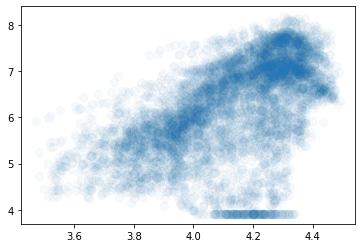

In [378]:
# check linear relationships before scaling
plt.scatter(X_train_before_scaled['temp_transformed'], X_train_before_scaled['count_transformed'], s=70, alpha=0.03)
plt.show()

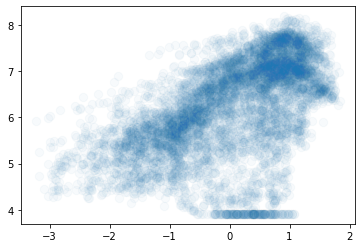

In [379]:
# after
plt.scatter(X_train['temp_transformed'], X_train['count_transformed'], s=70, alpha=0.03)
plt.show()

In [380]:
# preserved very well

##### save as a csv for future modeling use

In [381]:
X_train.to_csv('x_train_regression.csv', index=False)
X_test.to_csv('x_test_regression.csv', index=False)